In [1]:
import csv
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

path = r"cassava-leaf-disease-classification\10000Dataset224.npy"
data = np.load(path, allow_pickle=True).item()
df = pd.DataFrame(data)
# # 创建DataFrame
# df = pd.DataFrame(data)

# path = r"cassava-leaf-disease-classification\Dataset.csv"
# dataset = pd.read_csv(path)
# dataset = df.sample(n=10000, random_state=42)
dataset = df
# np.save(r"cassava-leaf-disease-classification\10000Dataset224.npy", dataset.to_dict(orient='list'))

images = np.stack(dataset['image_matrices'].values)
labels = dataset['labels'].values
# labels = np.array(labels, dtype=np.int32)

print(images.shape)
print(labels)

# 数据预处理
images = np.array(images).astype('float32') / 255.0  # Normalizaion
labels = tf.keras.utils.to_categorical(labels)  # convert label to one-hot code

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

(10000, 224, 224, 3)
['4' '3' '3' ... '3' '0' '0']


array([4, 3, 3, ..., 3, 0, 0])

In [7]:
class PrintEpochProgress(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs

    def on_train_begin(self, logs=None):
        self.epoch_progress = tqdm(total=self.total_epochs, desc='Epochs', position=0)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_progress.update(1)
        self.epoch_progress.set_postfix(loss=f"{logs['loss']:.4f}", accuracy=f"{logs['accuracy']:.4f}", val_loss=f"{logs['val_loss']:.4f}", val_accuracy=f"{logs['val_accuracy']:.4f}")
        

# 构建CNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax') 
])

# 编译模型
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

progress_callback = PrintEpochProgress(total_epochs=10)

# 训练模型
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1)

# 评估模型
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/30
113/113 [==============================] - 10s 61ms/step - loss: 1.1898 - accuracy: 0.6014 - val_loss: 1.0535 - val_accuracy: 0.6325
Epoch 2/30
113/113 [==============================] - 6s 57ms/step - loss: 1.0574 - accuracy: 0.6294 - val_loss: 0.9911 - val_accuracy: 0.6550
Epoch 3/30
113/113 [==============================] - 7s 58ms/step - loss: 1.0021 - accuracy: 0.6361 - val_loss: 0.9313 - val_accuracy: 0.6575
Epoch 4/30
113/113 [==============================] - 6s 55ms/step - loss: 0.9602 - accuracy: 0.6519 - val_loss: 0.9533 - val_accuracy: 0.6438
Epoch 5/30
113/113 [==============================] - 6s 57ms/step - loss: 0.9474 - accuracy: 0.6581 - val_loss: 0.8891 - val_accuracy: 0.6712
Epoch 6/30
113/113 [==============================] - 6s 55ms/step - loss: 0.8935 - accuracy: 0.6719 - val_loss: 0.8920 - val_accuracy: 0.6750
Epoch 7/30
113/113 [==============================] - 6s 55ms/step - loss: 0.8721 - accuracy: 0.6840 - val_loss: 0.9088 - val_accuracy: 0.668

KeyboardInterrupt: 

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Multiply, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, steps_per_epoch):
        super(CustomCallback, self).__init__()
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.progress_bar = None
    
    def on_epoch_begin(self, epoch, logs=None):
        self.progress_bar = tqdm(total=self.steps_per_epoch, desc=f'Epoch {epoch+1}/{self.total_epochs}')
        
    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.close()
        print(f"    loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
        
    def on_train_batch_end(self, batch, logs=None):
        self.progress_bar.update(1)
        

def attention_module(feature_map, input_channels):
    # Use 1x1 convolution to reduce dimensionality
    attention_features = Conv2D(filters=input_channels, kernel_size=(1, 1), padding='same')(feature_map)
    # Generate attention mask
    attention_mask = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same')(attention_features)
    # Apply attention mask to feature map through multiplication
    attention_applied = Multiply()([feature_map, attention_mask])
    return attention_applied, attention_mask

def global_weighted_average_pooling(feature_map, attention_mask):
    # Weight feature map
    weighted_feature_map = Multiply()([feature_map, attention_mask])
    # Sum attention mask
    sum_attention = tf.reduce_sum(attention_mask, axis=[1, 2], keepdims=True)
    # Weighted average pooling
    weighted_average_pool = weighted_feature_map / (sum_attention + tf.keras.backend.epsilon())
    # Global average pooling
    gap = tf.reduce_sum(weighted_average_pool, axis=[1, 2])
    return gap

# Input layer
input_shape = (224, 224, 3) 
inputs = Input(shape=input_shape)

# Pre-trained model
pre_model = EfficientNetB4(include_top=False, input_tensor=inputs)
x = pre_model.output

# for layer in pre_model.layers:
#     layer.trainable = False

print(x.shape)

# Batch normalization
x = BatchNormalization()(x)

# First additional convolutional layer
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)

print(x.shape)

# Second additional convolutional layer
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)

# # Second additional convolutional layer
# x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)

# Attention module
x, attention_mask = attention_module(x, input_channels=pre_model.output_shape[-1])

# Global weighted average pooling
x = global_weighted_average_pooling(x, attention_mask)

# Classification head
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(5, activation='softmax')(x)  

# Define the model
model = Model(inputs=inputs, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=10,
                    batch_size=32,
                    verbose=0, # Set verbose to 0 to avoid duplicate output
                    callbacks=[CustomCallback(total_epochs=10, steps_per_epoch=len(X_train)//32)]
                    )  # Print epoch progress

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

(None, 7, 7, 1792)
(None, 7, 7, 128)


Epoch 1/10:   2%|▏         | 5/250 [00:08<04:40,  1.14s/it]

Epoch 1/10:  90%|█████████ | 225/250 [00:32<00:03,  6.91it/s]


    loss: 993.8784 - accuracy: 0.6067 - val_loss: 1.1522 - val_accuracy: 0.6325


Epoch 2/10:  90%|█████████ | 225/250 [00:21<00:02, 10.24it/s]


    loss: 1.1857 - accuracy: 0.6161 - val_loss: 1.1554 - val_accuracy: 0.6325


Epoch 3/10:  39%|███▉      | 98/250 [00:08<00:13, 11.27it/s]

KeyboardInterrupt: 

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from gpflow.kernels import SquaredExponential
from gpflow.mean_functions import Constant
from gpflow.models import GPR, SVGP
import gpflow
from gpflow.likelihoods import Gaussian
from tensorflow.keras.layers import Softmax
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, steps_per_epoch):
        super(CustomCallback, self).__init__()
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.progress_bar = None
    
    def on_epoch_begin(self, epoch, logs=None):
        self.progress_bar = tqdm(total=self.steps_per_epoch, desc=f'Epoch {epoch+1}/{self.total_epochs}')
        
    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.close()
        print(f"    loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
        
    def on_train_batch_end(self, batch, logs=None):
        self.progress_bar.update(1)


# Create Convolutional Neural Network (CNN) model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False))  # Add pre-trained MobileNetV2 model
    print(model.output_shape)
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    for _ in range(10):  # Add 10 fully connected layers, each with 100 units, using ReLU activation function
        model.add(Dense(100, activation='relu'))
    return model

# Create DGP model
def create_dgp_model(input_shape, num_inducing_points):
    # Define the kernel function
    kernel = gpflow.kernels.SquaredExponential()

    # Define the inducing variable locations
    Z = np.random.rand(num_inducing_points, input_shape[0])

    # Define the mean function as a constant
    mean_function = gpflow.mean_functions.Constant()

    # Define the likelihood
    likelihood = gpflow.likelihoods.Gaussian()

    # Create the deep GP model
    dgp_model = SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=Z, mean_function=mean_function)

    # Convert the input shape to a tensor
    dgp_input = Input(shape=input_shape)

    # Get the predictions from the DGP model
    dgp_model_output = dgp_model.predict_f(dgp_input)[0]

    # Create a fully connected layer and apply the softmax activation function
    output_layer = Dense(5, activation='softmax')(dgp_model_output)

    # Create a new model that takes the input tensor and connects it to the output layer
    new_dgp_model = Model(inputs=dgp_input, outputs=output_layer)

    return new_dgp_model

# Create Keras Sequential model integrating CNN and DGP models
def create_dgcnn_model(cnn_model, dgp_model):
    dgcnn_model = Sequential()
    dgcnn_model.add(cnn_model)
    dgcnn_model.add(dgp_model)  # Add DGP model as prediction layer
    return dgcnn_model

# Set the shape of input data
input_shape = (224, 224, 3)  # Assume input image size is 224x224, 3 channels for RGB
num_inducing_points = 100

# Create CNN model and DGP model
cnn_model = create_cnn_model(input_shape)
cnn_output_shape = cnn_model.output_shape[1:]
dgp_model = create_dgp_model(cnn_output_shape, num_inducing_points)

# Create DGCNN model integrating CNN and DGP models
dgcnn_model = create_dgcnn_model(cnn_model, dgp_model)

# Compile the model
likelihood_loss = Gaussian()
dgcnn_model.compile(optimizer='adam', loss=likelihood_loss)

# Fit the model
dgcnn_model.fit(X_train, y_train,
                validation_split=0.1,
                epochs=10,
                batch_size=32,
                verbose=0,  # Set verbose to 0 to avoid duplicate output
                callbacks=[CustomCallback(total_epochs=10, steps_per_epoch=len(X_train)//32)])

(None, 7, 7, 1280)


AssertionError: (None, 100)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Multiply, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, steps_per_epoch):
        super(CustomCallback, self).__init__()
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.progress_bar = None
    
    def on_epoch_begin(self, epoch, logs=None):
        self.progress_bar = tqdm(total=self.steps_per_epoch, desc=f'Epoch {epoch+1}/{self.total_epochs}')
        
    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.close()
        print(f"    loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
        
    def on_train_batch_end(self, batch, logs=None):
        self.progress_bar.update(1)

def attention_module(feature_map, input_channels):
    # Use 1x1 convolution to reduce dimensionality
    attention_features = Conv2D(filters=input_channels, kernel_size=(1, 1), padding='same')(feature_map)
    # Generate attention mask
    attention_mask = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same')(attention_features)
    # Apply attention mask to feature map through multiplication
    attention_applied = Multiply()([feature_map, attention_mask])
    return attention_applied, attention_mask

def global_weighted_average_pooling(feature_map, attention_mask):
    # Weight feature map
    weighted_feature_map = Multiply()([feature_map, attention_mask])
    # Sum attention mask
    sum_attention = tf.reduce_sum(attention_mask, axis=[1, 2], keepdims=True)
    # Weighted average pooling
    weighted_average_pool = weighted_feature_map / (sum_attention + tf.keras.backend.epsilon())
    # Global average pooling
    gap = tf.reduce_sum(weighted_average_pool, axis=[1, 2])
    return gap

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Define model checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Input layer
input_shape = (224, 224, 3) 
inputs = Input(shape=input_shape)


# First Conv2D layer
x = Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))(inputs)
x = MaxPooling2D((2, 2))(x)

# Second Conv2D layer
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Third Conv2D layer
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Fourth Conv2D layer
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)


# Attention module
x, attention_mask = attention_module(x, input_channels=128)

# Global average pooling
x = GlobalAveragePooling2D()(x)

# Dense layers
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

# Compile the model
model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=80,
                    batch_size=64,
                    verbose=0, # Set verbose to 0 to avoid duplicate output
                    callbacks=[CustomCallback(total_epochs=80, steps_per_epoch=len(X_train)//64), early_stopping, checkpoint]
                    )  # Print epoch progress

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)




Epoch 1/80:   4%|▍         | 5/125 [00:04<01:14,  1.62it/s]

Epoch 1/80:  90%|█████████ | 113/125 [00:11<00:01,  9.44it/s]
d:\anaconda\envs\normal\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


    loss: 1.2247 - accuracy: 0.6115 - val_loss: 1.1117 - val_accuracy: 0.6325

Epoch 00001: val_accuracy improved from -inf to 0.63250, saving model to best_model.h5


Epoch 2/80:  90%|█████████ | 113/125 [00:05<00:00, 19.42it/s]


    loss: 1.1131 - accuracy: 0.6199 - val_loss: 1.0483 - val_accuracy: 0.6375

Epoch 00002: val_accuracy improved from 0.63250 to 0.63750, saving model to best_model.h5


Epoch 3/80:  90%|█████████ | 113/125 [00:05<00:00, 19.65it/s]


    loss: 1.0683 - accuracy: 0.6257 - val_loss: 1.0506 - val_accuracy: 0.6413

Epoch 00003: val_accuracy improved from 0.63750 to 0.64125, saving model to best_model.h5


Epoch 4/80:  31%|███       | 39/125 [00:01<00:04, 18.93it/s]

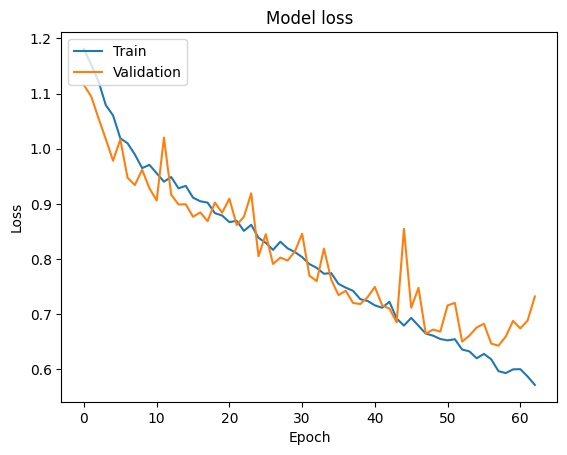

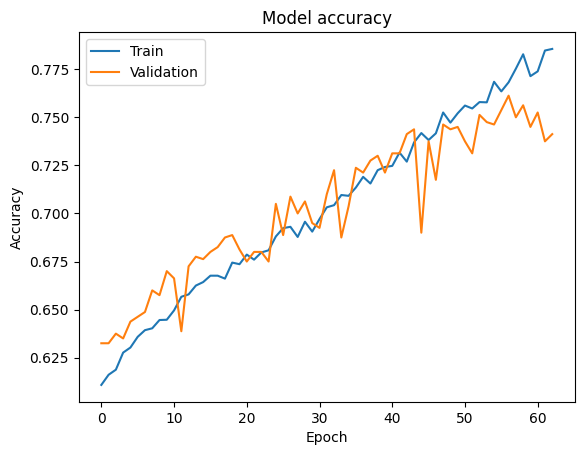

In [4]:
def plot_history(history, save_path=None):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(save_path + '3layer_loss.png')
    plt.show()
    plt.clf()  # Clear the figure to plot the next graph

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(save_path + '3layer_accuracy.png')
    plt.show()
        
plot_history(history, '')

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Get feature map from the model trained before
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

train_features = feature_extractor.predict(X_train)
print(train_features.shape)
test_features = feature_extractor.predict(X_test)

# Convert multi-class target variable to one-dimensional array
y_train_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# train SVM
svm_model = SVC(kernel='rbf', C = 1)
svm_model.fit(train_features, y_train_flat)

# evaluate model on test set
y_pred = svm_model.predict(test_features)
accuracy = accuracy_score(y_test_flat, y_pred)
print("Accuracy:", accuracy)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.